In [2]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,plot_outline,plot_dendrogram,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
import numpy as np

<ipython-input-3-65dd99a0e0e1>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abridge["t_cluster"]=abridge["topology"].map(dic)


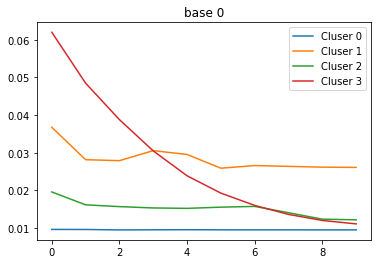

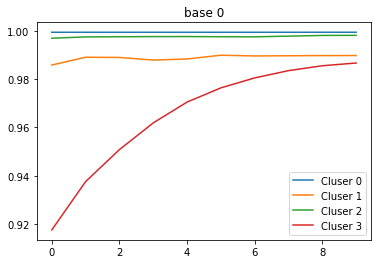

In [3]:
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is graph of median topologies and dendrogram cluster graph
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
loud=[0,0,0,0,0,1,1]
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=4
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest = ["H2@100 bar/243K (wt%)"]
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],'topology']]=data[['MOF ID',interest[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],'topology', 'Pc1', 'Pc2', 'Cluster']]
# generate holder for dataframes for looping 

if loud[2]:
    a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
    plt.scatter(a["Pc1"],a["Pc2"])
    color = AgglomerativeClustering(n_clusters=g_comp).fit_predict(a)
    #color=gm.predict(a)
    plt.scatter(a["Pc1"],a["Pc2"],c=color)
    plt.legend()
    plot_outline(abridge)


    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(a)
        
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(20)
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model,a, truncate_mode="level", p=3)
a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
model = AgglomerativeClustering(n_clusters=g_comp)
model = model.fit(a)
model.labels_
dic={}
for a,b in zip(a.index,model.labels_):
    dic[a]=b
abridge["t_cluster"]=abridge["topology"].map(dic)
O_M_Cluster=[]
for i in sorted(abridge["t_cluster"].unique()):
    Temp=abridge[abridge["t_cluster"]==i]
    O_M_Cluster.append(Temp)

# parameters for neural net
epochs = 500
batch_size = 128
input_size = 5
output_size = 1
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
resize=False
if resize:
    M_Cluster=size_clusters(O_M_Cluster)
else:
    M_Cluster=O_M_Cluster
#Base Cluster for transfer learning 
#specify cluster
cluster=0
data = M_Cluster[0]
#checks for index problem
data = data.reset_index(drop=True)
#computer requirements 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = os.getcwd()

features = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
#create splits 
df_train,df_val,df_test=prep_data_splits(data,features,interest)
#create dataset loader objects for looping through data,default test size is .2
first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

third = MyDataset(df_test, interest, features)
test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
#intialize holders for data
train_loss = []
train_r_2 = []
val_loss = []
val_r_2 = []
test_loss = []
test_r_2 = []
net_time = []

# initalize model
model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
criterion = nn.MSELoss()
learning_rate = trial_parameters["lr"]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#Create engine for running NN, pytorch

def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)
#sets up loss and R scores and stores values
#Note: note sure if can condense this into a module b/c of decorator and namespace
@trainer.on(Events.EPOCH_COMPLETED(every=50))
def store_metrics(engine):
    end = time.time()
    e = engine.state.epoch
    out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
    out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
    out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
    out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
    out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
    out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
    train_loss.append(out)
    train_r_2.append(out1)
    val_loss.append(out2)
    val_r_2.append(out3)
    test_loss.append(out4)
    test_r_2.append(out5)
    net_time.append(end-start)
    if loud[3]:
        print(e)
#Creates timer and runs trainer 
start = time.time()
trainer.logger.disabled=True
trainer.run(train_loader, max_epochs=epochs)
plt.show()

if loud[4]:
    plt.plot(val_r_2)
    plt.plot(train_r_2,label="t")
    plt.plot(test_r_2,label="real")
    plt.legend()
    plt.show()
    plt.plot(val_loss)
    plt.plot(train_loss,label="t")
    plt.plot(test_loss,label="real")
    plt.legend()
    plt.show()
#save base model for transfer into other clusters in loop
torch.save(model, "Temp.ckpt")
#transfer learning part
#stores meta data
test_loss_holder=[]
test_r2_holder=[]
#loops through clusters
for count,i in enumerate(M_Cluster):
    train_loss = []
    train_r_2 = []
    val_loss = []
    val_r_2 = []
    test_loss = []
    test_r_2 = []
    net_time = []
    #loading model again
    model=torch.load("Temp.ckpt")
    descriptor_columns = [
        "void fraction",
        "Vol. S.A.",
        "Grav. S.A.",
        "Pore diameter Limiting",
        "Pore diameter Largest",
    ]
#turns off model learning
    model.fc1.weight.requires_grad = False
    model.fc1.bias.requires_grad = False
    model.fc2.weight.requires_grad = False
    model.fc2.bias.requires_grad = False

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
    )
    #Base Cluster for transfer learning 
    data = i
    #checks for index problem
    data = data.reset_index(drop=True)
    #splits data set
    df_train,df_val,df_test=prep_data_splits(data,features,interest)
    #create dataset loader objects for looping through data,default test size is .2
    first = MyDataset(df_train, interest, features)
    train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

    second = MyDataset(df_val, interest, features)
    val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

    third = MyDataset(df_test, interest, features)
    test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

    #once again making training and testing engine
    def train_step_1(engine, batch):
        x, y = batch
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        return loss.item()


    transfer_trainer = Engine(train_step_1)
    @transfer_trainer.on(Events.EPOCH_COMPLETED(every=50))
    def store_metrics(engine):
        end = time.time()
        e = engine.state.epoch
        out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
        out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
        out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
        out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
        out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
        out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
        train_loss.append(out)
        train_r_2.append(out1)
        val_loss.append(out2)
        val_r_2.append(out3)
        test_loss.append(out4)
        test_r_2.append(out5)
        net_time.append(end-start)
        if loud[5]:
            print(e)
    #runs model
    transfer_trainer.logger.disabled=True
    transfer_trainer.run(train_loader, max_epochs=epochs)
    test_loss_holder.append(test_loss)
    test_r2_holder.append(test_r_2)
#plots all clusers learning in terms of test set
if loud[6]:
    plt.title(f"base {cluster}")
    for count,i in enumerate(test_loss_holder):
        plt.plot(i,label=f"Cluser {count}")
    plt.legend()
    plt.show()
    plt.title(f"base {cluster}")
    for count,i in enumerate(test_r2_holder):
        plt.plot(i,label=f"Cluser {count}")
    plt.legend()

In [6]:
for i in M_Cluster:
    print(len(i))
    number=i["t_cluster"].unique()
    print(i["topology"].unique(),f"Cluster {number[0]}")

5422
['bor' 'crs' 'csq' 'ctn' 'rhrb' 'sodb' 'spn' 'srsb' 'ssa' 'stp' 'tbo'
 'the' 'tpt'] Cluster 0
3288
['acs' 'flu' 'ftw' 'gar' 'lvtb' 'nia' 'ocu' 'pcu' 'reo' 'rht' 'scu'] Cluster 1
4235
['diab' 'iac' 'lcsb' 'nbob' 'pth' 'pto' 'pts' 'pyr' 'qtz' 'she' 'soc'
 'ssb'] Cluster 2
561
['bcs' 'bct' 'bcu' 'fcu' 'ith'] Cluster 3


In [26]:
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is graph of median topologies and dendrogram cluster graph
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
loud=[0,0,0,0,0,0,0,1]
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=4
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest = ["H2@100 bar/243K (wt%)"]
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],'topology']]=data[['MOF ID',interest[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],'topology', 'Pc1', 'Pc2', 'Cluster']]
# generate holder for dataframes for looping 

if loud[2]:
    a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
    plt.scatter(a["Pc1"],a["Pc2"])
    color = AgglomerativeClustering(n_clusters=g_comp).fit_predict(a)
    #color=gm.predict(a)
    plt.scatter(a["Pc1"],a["Pc2"],c=color)
    plt.legend()
    plot_outline(abridge)


    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(a)
        
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(20)
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model,a, truncate_mode="level", p=3)
a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
model = AgglomerativeClustering(n_clusters=g_comp)
model = model.fit(a)
model.labels_
dic={}
for a,b in zip(a.index,model.labels_):
    dic[a]=b
abridge["t_cluster"]=abridge["topology"].map(dic)
O_M_Cluster=[]
for i in sorted(abridge["t_cluster"].unique()):
    Temp=abridge[abridge["t_cluster"]==i]
    O_M_Cluster.append(Temp)

# parameters for neural net
epochs = 500
epochs=50
batch_size = 128
input_size = 5
output_size = 1
resolution=50
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
resize=False
#specify cluster
meta_trials=100
meta=[]
if loud[7]:
    counter=0
for i in range(meta_trials):
    #create holder for meta anaylsis
    mega={}
    for i in range(len(M_Cluster)):
        mega[i]=[]
    if resize:
        M_Cluster=size_clusters(O_M_Cluster)
    else:
        M_Cluster=O_M_Cluster
    for count,g in enumerate(M_Cluster):
        cluster=count
        data = g
        #checks for index problem
        data = data.reset_index(drop=True)
        #computer requirements 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        base_path = os.getcwd()

        features = [
            "void fraction",
            "Vol. S.A.",
            "Grav. S.A.",
            "Pore diameter Limiting",
            "Pore diameter Largest",
        ]
        #create splits 
        df_train,df_val,df_test=prep_data_splits(data,features,interest)
        #create dataset loader objects for looping through data,default test size is .2
        first = MyDataset(df_train, interest, features)
        train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

        second = MyDataset(df_val, interest, features)
        val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

        third = MyDataset(df_test, interest, features)
        test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
        #intialize holders for data
        train_loss = []
        train_r_2 = []
        val_loss = []
        val_r_2 = []
        test_loss = []
        test_r_2 = []
        net_time = []

        # initalize model
        model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
        criterion = nn.MSELoss()
        learning_rate = trial_parameters["lr"]
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        #Create engine for running NN, pytorch

        def train_step(engine, batch):
            x, y = batch
            model.train()
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            return loss.item()

        trainer = Engine(train_step)
        #sets up loss and R scores and stores values
        #Note: note sure if can condense this into a module b/c of decorator and namespace
        @trainer.on(Events.EPOCH_COMPLETED(every=50))
        def store_metrics(engine):
            end = time.time()
            e = engine.state.epoch
            out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
            out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
            out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
            out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
            out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
            out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
            train_loss.append(out)
            train_r_2.append(out1)
            val_loss.append(out2)
            val_r_2.append(out3)
            test_loss.append(out4)
            test_r_2.append(out5)
            net_time.append(end-start)
            if loud[3]:
                print(e)
        #Creates timer and runs trainer 
        start = time.time()
        trainer.logger.disabled=True
        trainer.run(train_loader, max_epochs=epochs)
        plt.show()

        if loud[4]:
            plt.plot(val_r_2)
            plt.plot(train_r_2,label="t")
            plt.plot(test_r_2,label="real")
            plt.legend()
            plt.show()
            plt.plot(val_loss)
            plt.plot(train_loss,label="t")
            plt.plot(test_loss,label="real")
            plt.legend()
            plt.show()
        #save base model for transfer into other clusters in loop
        torch.save(model, "Temp.ckpt")
        #transfer learning part
        #stores meta data
        test_loss_holder=[]
        test_r2_holder=[]
        #loops through clusters
        for count,i in enumerate(M_Cluster):
            train_loss = []
            train_r_2 = []
            val_loss = []
            val_r_2 = []
            test_loss = []
            test_r_2 = []
            net_time = []
            #loading model again
            model=torch.load("Temp.ckpt")
            descriptor_columns = [
                "void fraction",
                "Vol. S.A.",
                "Grav. S.A.",
                "Pore diameter Limiting",
                "Pore diameter Largest",
            ]
        #turns off model learning
            model.fc1.weight.requires_grad = False
            model.fc1.bias.requires_grad = False
            model.fc2.weight.requires_grad = False
            model.fc2.bias.requires_grad = False

            optimizer = optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
            )
            #Base Cluster for transfer learning 
            data = i
            #checks for index problem
            data = data.reset_index(drop=True)
            df_train,df_val,df_test=prep_data_splits(data,features,interest)
            #create dataset loader objects for looping through data,default test size is .2
            first = MyDataset(df_train, interest, features)
            train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

            second = MyDataset(df_val, interest, features)
            val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

            third = MyDataset(df_test, interest, features)
            test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

            #once again making training and testing engine
            def train_step_1(engine, batch):
                x, y = batch
                model.train()
                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                return loss.item()


            transfer_trainer = Engine(train_step_1)
            n=int(epochs/resolution)
            @transfer_trainer.on(Events.EPOCH_COMPLETED(every=n))
            def store_metrics(engine):
                end = time.time()
                e = engine.state.epoch
                out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
                out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
                out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
                out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
                out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
                out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
                train_loss.append(out)
                train_r_2.append(out1)
                val_loss.append(out2)
                val_r_2.append(out3)
                test_loss.append(out4)
                test_r_2.append(out5)
                net_time.append(end-start)
                if loud[5]:
                    print(e)
            #runs model
            transfer_trainer.logger.disabled=True
            transfer_trainer.run(train_loader, max_epochs=epochs)
            test_loss_holder.append(test_loss)
            test_r2_holder.append(test_r_2)
        #because error tends to be low, only anaylizing r2 scores
            mega[count].append(test_r_2)
        #plots all clusers learning in terms of test set
        if loud[6]:
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_loss_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
            plt.show()
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_r2_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
    if loud[7]:
        counter+=1
        print(counter)
    meta.append(mega)

<ipython-input-26-9517cdcb6de8>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abridge["t_cluster"]=abridge["topology"].map(dic)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [ ]:
for i in range(4):
    display(abridge[abridge["t_cluster"]==i].groupby("topology").count())

In [27]:
import numpy as np
base={}
for count,i in enumerate((meta[0])):
    i=meta[0][i]
    base[count]=(i)
for i in meta[1:]:
    for g in i:
        for count,z in enumerate(i[g]):
            base[g][count]=np.array(base[g][count])+np.array(z)

NameError: name 'n' is not defined

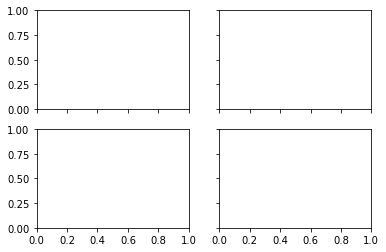

In [13]:
n=1
anaylsis(base)

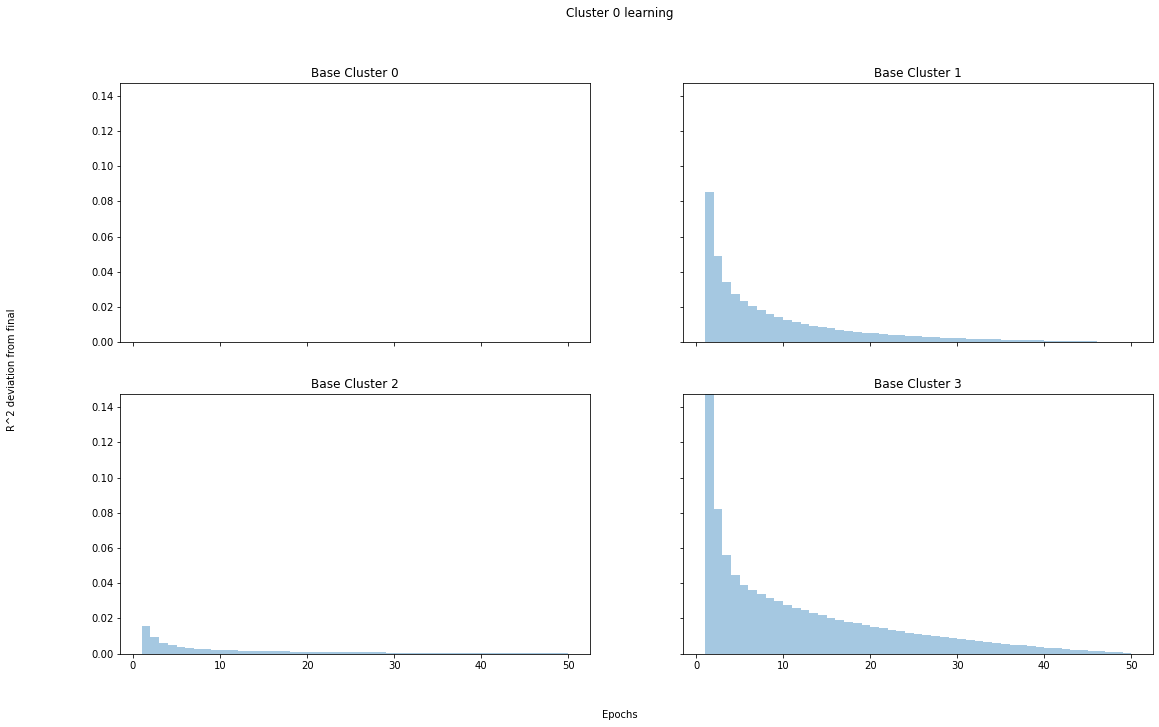

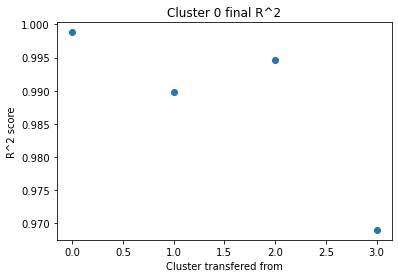

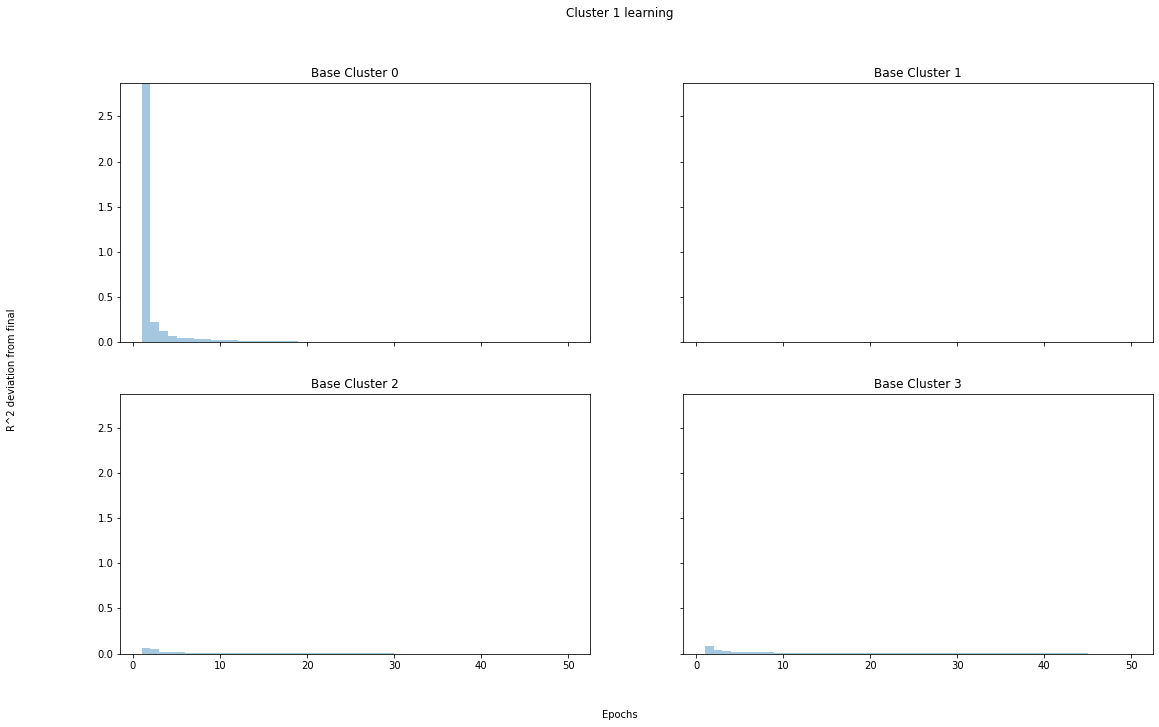

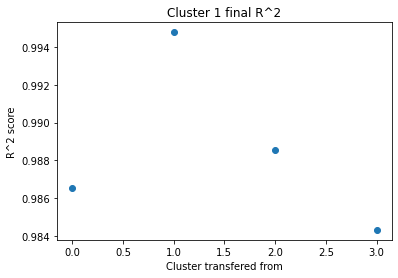

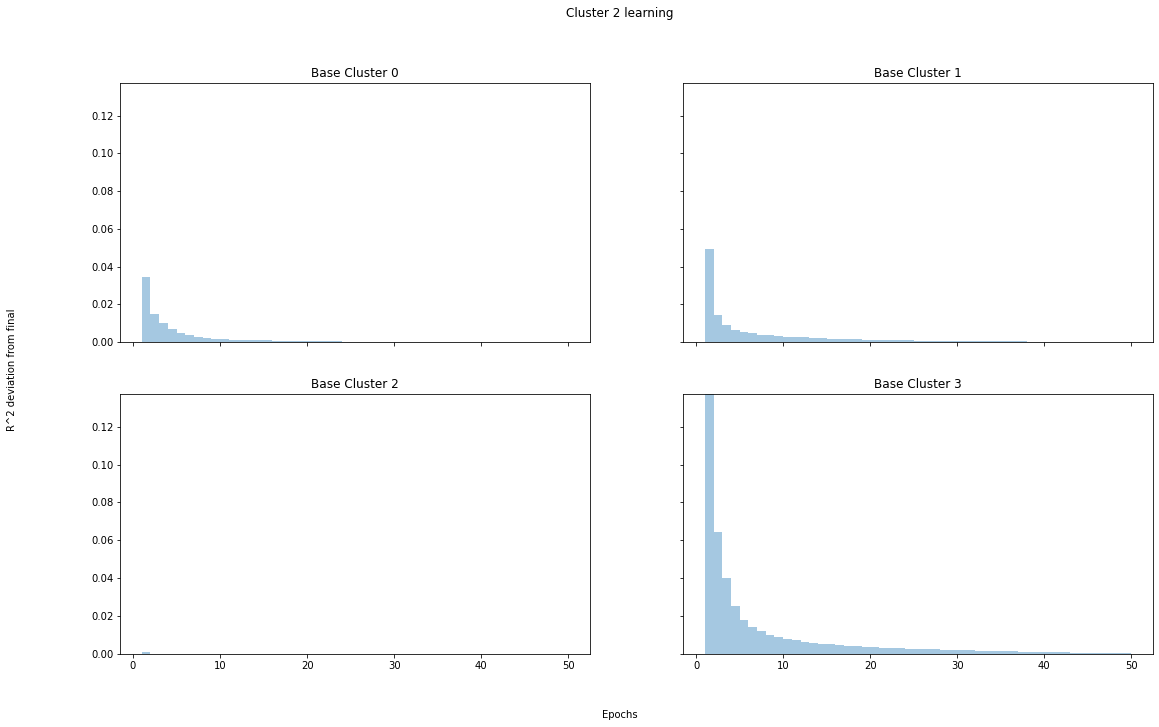

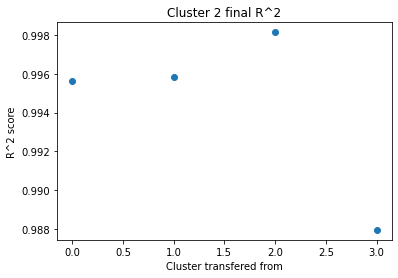

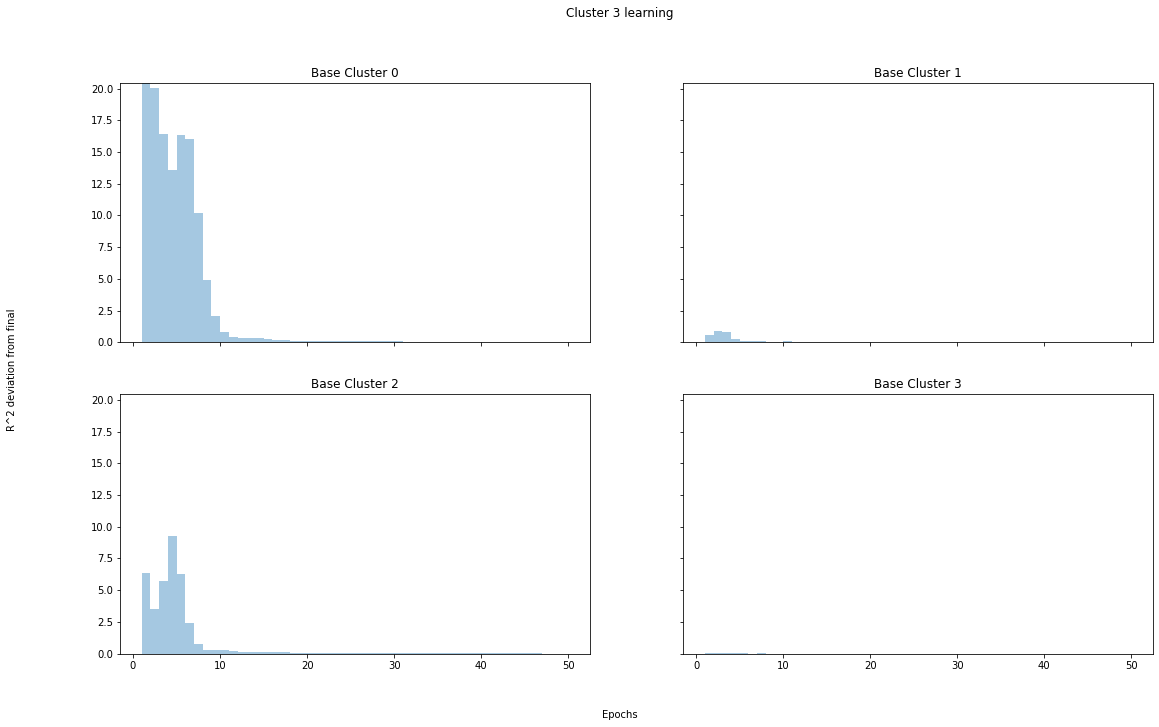

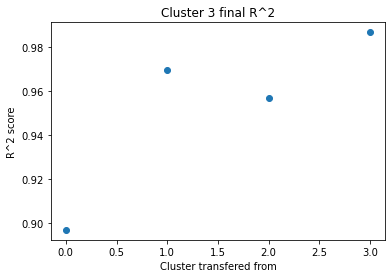

In [28]:
    adjust=100
    mega=base
    for count,i in enumerate(mega):
        hold=[]
        for g in mega[i]:
            scatter_holder=[]
            hold.append(np.array(g))
        fig, axs = plt.subplots(int(len(hold)/2),2, sharex=True,sharey=True)
        rotate=0
        base1=0
        m_set=0
        min_set=0
        for z in range(len(hold)):
            scatter_holder.append(hold[z][-1])
            if m_set <= max(-(hold[z]-hold[z][-1])):
                m_set=max(-(hold[z]-hold[z][-1]))
            if min_set <= min(-(hold[z]-hold[z][-1])):
                min_set=min(-(hold[z]-hold[z][-1]))
            axs[base1,rotate].fill_between(np.linspace(n,epochs,len(hold[z])),-(hold[z]-hold[z][-1])/adjust, step="post", alpha=0.4,label=f"Base Transfer {z}")
            #axs[base,rotate].scatter(np.linspace(n,epochs,len(hold[z])),-(hold[z]-hold[z][-1]),label=f"Base Transfer {z}")
            fig.suptitle(f"Cluster {count} learning")
            axs[base1,rotate].set_title(f"Base Cluster {z}")
            if rotate==1:
                base1+=1
                rotate=0
            else:
                rotate+=1
        fig.set_size_inches(18.5, 10.5)
        fig.text(0.04, 0.5, "R^2 deviation from final", va='center', rotation='vertical')
        fig.text(0.5, 0.04, "Epochs", ha='center')
        plt.ylim(min_set/adjust,m_set/adjust)
        plt.show()
        plt.scatter(range(len(scatter_holder)),np.array(scatter_holder)/adjust,label=f"Base Transfer {z}")
        plt.title(f"Cluster {count} final R^2")
        plt.ylabel("R^2 score")
        plt.xlabel("Cluster transfered from")
        plt.show()

In [15]:
len(meta)

400

In [20]:
base

2